In [1]:
import pandas as pd
import numpy as np
import tensorly as tl
from tensorly.decomposition import tucker
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
import xgboost as xg
from scipy.fft import dct
from sklearn import metrics
import matplotlib.pyplot as plt
import sys

sys.path.insert(1,'D:\TMU_codes\Thesis_codes\codes')
# for line in sys.path:
#      print (line)
# from package.featureSelection_SICE import *
from package.loadDb import *
from package.featureSelection_TENSORIZED import *

In [2]:
# import kaggle dataset
address = "..\database\kaggleDataFrame"

data_with_target= load_kaggle_dataframe(address+"\dataframes.csv")

# data_with_target=data_with_target.iloc[:6000]

data_without_target = data_with_target.drop(['DEMAND'],axis=1)

print("data with target size = ",data_with_target.shape )


data with target size =  (46968, 11)


In [3]:
window_size=4
# num_comp will be selected automaticly based on energy
testSize=500
tol_u0=.95 # to find reduced window size
tol_u1=.99 # to find reduced feature numbers
interval=2000


In [4]:

pca_list=[]
fselection_list = []
num_comp_list=[]
pca_time_list=[]
pca_all_list=[]

start=0
end=interval

while data_with_target.shape[0] >= end:

    X=data_with_target.iloc[start : end,:-1]
    Y=data_with_target.iloc[start+window_size-1 : end,-1]

    num_comp, new_data = generate_data_HOSVD(window_size,X,tol_u0,tol_u1)

    
    X_pca_all=compute_pca(X,num_comp=num_comp)
    Y_pca_all=data_with_target.iloc[start : end,-1]

    # if we ignore first samples that their targets arent used in our method:
    X_pca=compute_pca(X.iloc[window_size-1:],num_comp=num_comp)
    Y_pca=Y

    pca_over_time=tensorizing(window_size,X)
    pca_over_time=data_unfold(pca_over_time)
    X_pca_over_time=compute_pca(pca_over_time,num_comp=num_comp)



    rmse_fselection=xgboost_reg_error(new_data,Y,testSize)

    rmse_pca_all=xgboost_reg_error(X_pca_all,Y_pca_all,testSize)

    rmse_pca=xgboost_reg_error(X_pca,Y_pca,testSize)


    rmse_pca_time=xgboost_reg_error(X_pca_over_time,Y,testSize)

    
    pca_list.append(rmse_pca)
    fselection_list.append(rmse_fselection)
    num_comp_list.append(num_comp)
    pca_time_list.append(rmse_pca_time)
    pca_all_list.append(rmse_pca_all)
    start=start + interval
    end=end + interval 
    print("---------------------------------------------------")

print ("number of component list:",np.array(num_comp_list))
print ("RMSE of QR_f_s model is :",np.array(fselection_list).round( decimals=2))
print ("RMSE of pca model is    :",np.array(pca_list).round( decimals=2))



data without target size is (2000, 10)
tensorized data size is (4, 10, 1997)
data size is (4, 5, 1997)
unfolded data size is (1997, 20)
data without target size is (2000, 10)
tensorized data size is (4, 10, 1997)
unfolded data size is (1997, 40)
---------------------------------------------------
data without target size is (2000, 10)
tensorized data size is (4, 10, 1997)
data size is (4, 5, 1997)
unfolded data size is (1997, 20)
data without target size is (2000, 10)
tensorized data size is (4, 10, 1997)
unfolded data size is (1997, 40)
---------------------------------------------------
data without target size is (2000, 10)
tensorized data size is (4, 10, 1997)
data size is (4, 5, 1997)
unfolded data size is (1997, 20)
data without target size is (2000, 10)
tensorized data size is (4, 10, 1997)
unfolded data size is (1997, 40)
---------------------------------------------------
data without target size is (2000, 10)
tensorized data size is (4, 10, 1997)
data size is (4, 5, 1997)
unf

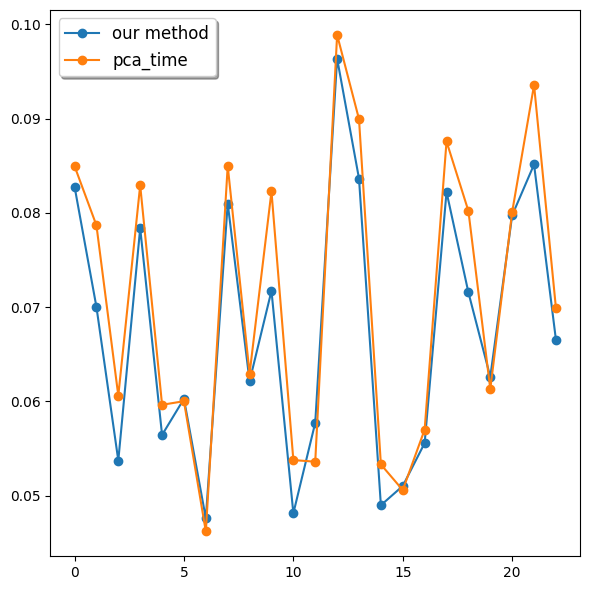

In [8]:
t = np.arange(len(fselection_list))
t.shape
fig, ax = plt.subplots()
ax.plot(t,fselection_list,marker = 'o', label='our method')
ax.plot(t,pca_time_list,marker = 'o', label='pca_time')
# ax.plot(t,pca_all_list,marker = 'o', label='pca [all]')

# Plot another line on the same chart/graph
# ax.plot(t, pca_list,marker = 'o', label='pca [winsize-1:]')
legend = ax.legend(loc='upper left', shadow=True, fontsize='large')
plt.show()

In [6]:
# print("fselection_list      pca_list")
# for x, y in zip(np.array(fselection_list).round( decimals=4),np.array(pca_list).round( decimals=4)):
#     print(x, y, sep='\t\t')
#     print("---------------")

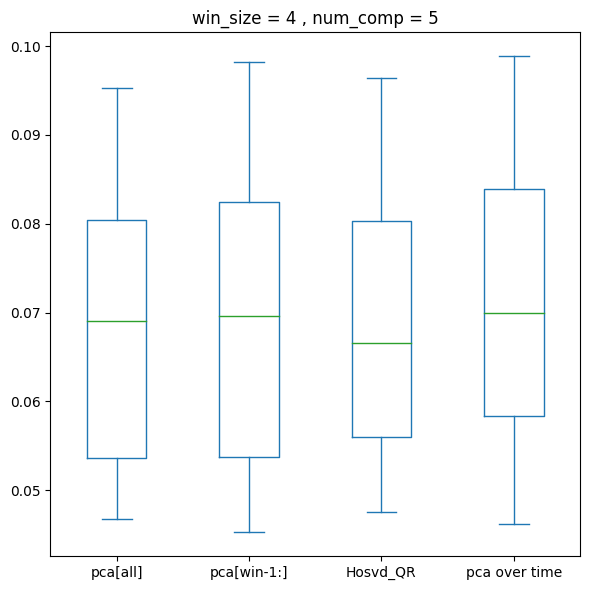

In [7]:

# Set the figure size
plt.rcParams["figure.figsize"] = [6,6]
plt.rcParams["figure.autolayout"] = True

# Pandas dataframe
data_plot = pd.DataFrame({"pca[win-1:]":np.array(pca_list) , "Hosvd_QR":np.array(fselection_list), "pca over time":np.array(pca_time_list),"pca[all]":np.array(pca_all_list)})

# Plot the dataframe
ax = data_plot[["pca[all]","pca[win-1:]", 'Hosvd_QR',"pca over time"]].plot(kind='box', title='win_size = {} , num_comp = {}'.format(window_size,num_comp))

# Display the plot
plt.show()